In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

# plt.rcParams["figure.dpi"] = 300

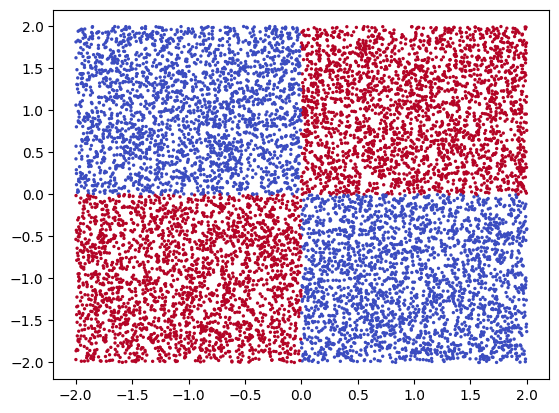

In [27]:
def generate_data_bimodal(n_samples: int):
    n_samples_distr_0 = np.random.binomial(n_samples, 0.5)
    n_samples_distr_1 = n_samples - n_samples_distr_0

    mean_0, std_0 = -1, 0.5
    mean_1, std_1 = 1, 0.5

    x_0 = torch.normal(mean_0, std_0, size=(n_samples_distr_0, 2))
    x_1 = torch.normal(mean_1, std_1, size=(n_samples_distr_1, 2))

    x = torch.cat([x_0, x_1])
    y = torch.zeros(n_samples, dtype=torch.long)
    y[-n_samples_distr_1:] = 1

    random_permutation = torch.randperm(n_samples)
    x = x[random_permutation]
    y = y[random_permutation]

    return x, y


def generate_data_trimodal(n_samples: int):
    n_samples_distr_outer = int(n_samples * 0.4)
    n_samples_distr_middle = n_samples - 2 * n_samples_distr_outer

    mean_outer_left, std_outer_left = -1.5, 0.5
    mean_outer_right, std_outer_right = 1.5, 0.5
    mean_middle, std_middle = 0.0, 0.3

    x_outer_left = torch.normal(
        mean_outer_left, std_outer_left, size=(n_samples_distr_outer, 2)
    )
    x_outer_right = torch.normal(
        mean_outer_right, std_outer_right, size=(n_samples_distr_outer, 2)
    )
    x_middle = torch.normal(mean_middle, std_middle, size=(n_samples_distr_middle, 2))

    x = torch.cat([x_outer_left, x_outer_right, x_middle])
    y = torch.zeros(n_samples, dtype=torch.long)
    y[-n_samples_distr_middle:] = 1

    random_permutation = torch.randperm(n_samples)
    x = x[random_permutation]
    y = y[random_permutation]

    return x, y


def generate_data_checker(n_samples: int):
    x = torch.rand((n_samples, 2)) * 4 - 2

    y = torch.zeros(n_samples, dtype=torch.long)
    y[(x[:, 0] > 0) & (x[:, 1] > 0)] = 1
    y[(x[:, 0] < 0) & (x[:, 1] < 0)] = 1

    return x, y

# TODO try different distributions
generate_data = generate_data_checker

x, y_t = generate_data(10000)
plt.scatter(*x.T, c=y_t, cmap="coolwarm", s=2)
plt.show()

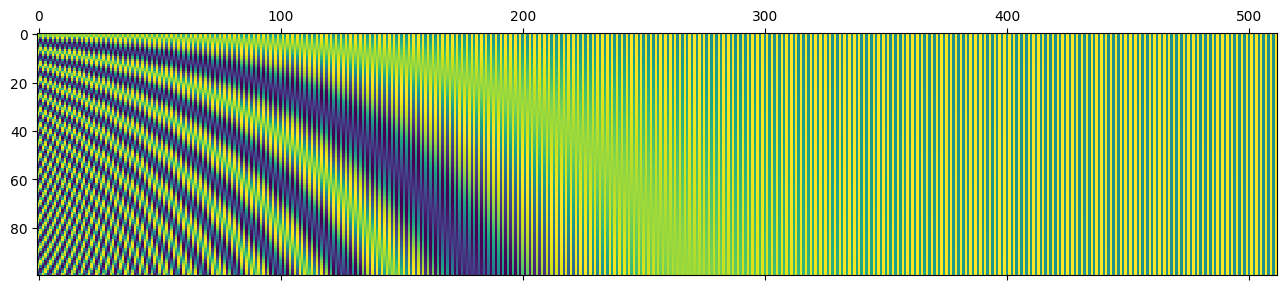

In [28]:
def get_positional_encoding(t: np.ndarray, d: int = 512, n: int=10_000) -> np.ndarray:
    """get positional encoding for a time vector t

    Args:
        t (np.ndarray): time indices. Integers >= 0 with shape (n_samples, )
        d (int, optional): dimension of the final positional encoding. Has to be an even number Defaults to 512. 
        n (int, optional): User defined scalar. Defaults to 10_000.

    Returns:
        np.ndarray: (n_samples, d)
    """
    n_samples = len(t)
    pos_enc = np.zeros((n_samples, d))
    
    pos_index = np.arange(d // 2)
    denominator = np.power(n, 2 * pos_index / d)

    pos_enc[:, 2*pos_index] = np.sin(t[:, None] / denominator[None])
    pos_enc[:, 2*pos_index + 1] = np.cos(t[:, None] / denominator[None])

    return pos_enc

plt.matshow(get_positional_encoding(np.arange(100), d=512, n=10_000))

In [29]:
T = 1000  # Number of diffusion timesteps
beta_start = 1e-4
beta_end = 0.02

# Compute beta, alpha, and alpha_bar
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

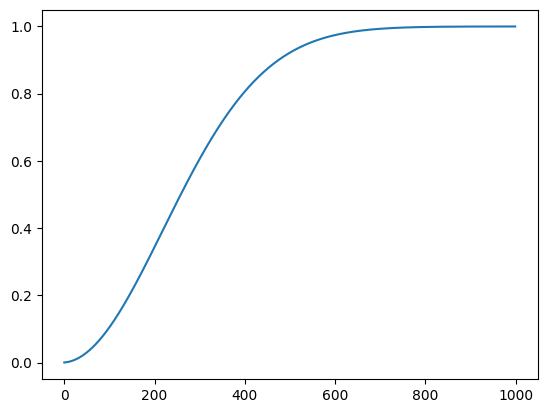

In [30]:
plt.plot(1- alphas_bar)


# Learn Classifier

100%|██████████| 10000/10000 [00:33<00:00, 295.64it/s]


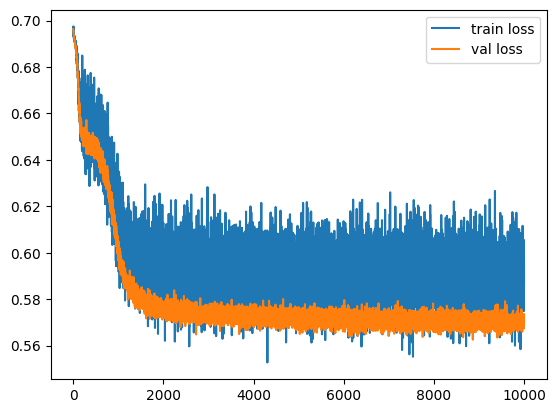

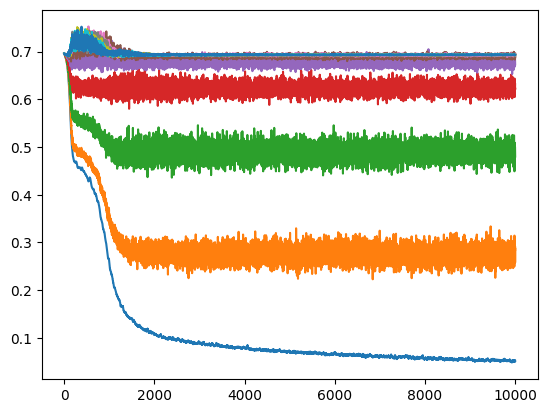

In [31]:
classifier = nn.Sequential(
    nn.Linear(3, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 2),
)
classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.0004)

x_val, y_val = generate_data(1000)

train_loss = []
val_loss = []

n_epochs = 10000
for epoch in tqdm(range(n_epochs)):
    x_train, y_train = generate_data(1000)
    t = torch.from_numpy(np.random.choice(T, size=len(x_train)))
    alpha_bar = alphas_bar[t, None]

    y_t = torch.normal(0, 1, size=(x_train.shape))
    x_t = np.sqrt(alpha_bar) * x_train + np.sqrt(1 - alpha_bar) * y_t

    inp = torch.cat([x_t, (t / T)[:, None]], dim=1).float()
    # pos_enc = torch.from_numpy(get_positional_encoding(t.numpy(), d=2)).float()
    # inp = x_t + pos_enc
    y_hat = classifier(inp)
    loss = classifier_criterion.forward(y_hat, y_train)
    classifier_optimizer.zero_grad()
    loss.backward()
    classifier_optimizer.step()

    train_loss.append(loss.item())

    # TODO add eval again
    t = torch.from_numpy(np.linspace(0, T - 1, 11)).int()
    alpha_bar = alphas_bar[t, None, None]
    y_t = torch.normal(0, 1, size=[len(t), *x_val.shape])
    x_t = np.sqrt(alpha_bar) * x_val[None] + np.sqrt(1 - alpha_bar) * y_t
    inp = torch.cat([x_t, (t / T)[:, None, None].repeat((1, len(x_val), 1))], dim=2).float()
    # pos_enc = torch.from_numpy(get_positional_encoding(t.numpy(), d=2)).float()
    # inp = x_t + pos_enc[:, None]
    val_loss.append([classifier_criterion.forward(y_hat, y_val).item() for y_hat in classifier(inp)])

val_loss = torch.tensor(val_loss)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss.mean(dim=1), label="val loss")
plt.legend()
plt.show()
plt.plot(val_loss)
plt.show()

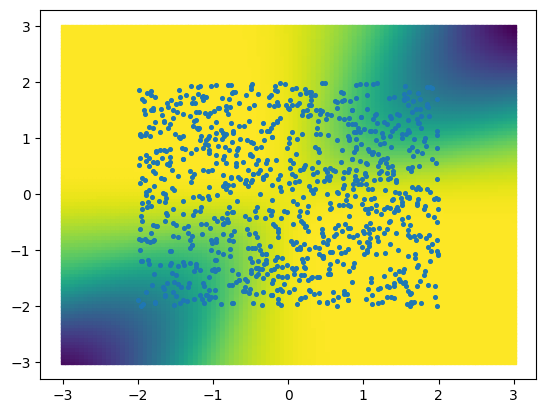

In [33]:
diff_time = 0.1  # TODO play around between 0 and 1, time dependent classifier
mesh = (
    torch.stack(
        torch.meshgrid([torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100)])
    )
    .reshape(2, -1)
    .T
)
# pos_enc = torch.from_numpy(get_positional_encoding(np.ones(len(mesh)) * 0, d=2)).float()
# inp = mesh + pos_enc
inp = torch.cat([mesh, diff_time * torch.ones(len(mesh), 1)], dim=1)
pred = classifier.forward(inp)

plt.scatter(
    *mesh[:, :2].T, c=F.log_softmax(pred, dim=1)[:, 0].detach().numpy(), marker="s", s=7
)
plt.scatter(*x_val.T, s=7)
plt.show()

# Learn Diffusion Model

100%|██████████| 400/400 [00:01<00:00, 231.58it/s]


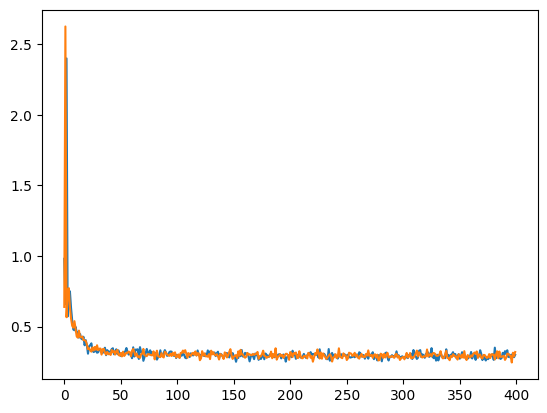

In [34]:
# TODO both the classifier and diffusion model should get the time info via a sinusoidal encoding layer
diffusion_model = nn.Sequential(
    nn.Linear(3, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    nn.Linear(64, 2),
)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=0.04)

train_loss = []
val_loss = []

n_epochs = 400
for epoch in tqdm(range(n_epochs)):
    # sample diffusion process
    x_train, y_train = generate_data(1024)
    t = torch.from_numpy(np.random.choice(T, size=len(x_train)))
    alpha_bar = alphas_bar[t, None]

    y_t = torch.normal(0, 1, size=(x_train.shape))
    x_t = np.sqrt(alpha_bar) * x_train + np.sqrt(1 - alpha_bar) * y_t

    inp = torch.cat([x_t, (t / T)[:, None]], dim=1).float()
    pred = diffusion_model.forward(inp)

    loss = criterion.forward(pred, y_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    # validate model
    diffusion_model.eval()
    t = torch.from_numpy(np.random.choice(T, size=len(x_val)))
    alpha_bar = alphas_bar[t, None]

    y_t = torch.normal(0, 1, size=(x_val.shape))
    x_t = np.sqrt(alpha_bar) * x_val + np.sqrt(1 - alpha_bar) * y_t

    inp = torch.cat([x_t, (t / T)[:, None]], dim=1).float()
    pred = diffusion_model.forward(inp)
    loss = criterion.forward(pred, y_t)

    val_loss.append(loss.item())
    diffusion_model.train()

plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

# Sample From diffusion model

In [38]:
@torch.enable_grad()
def get_classifier_grad(classifier, input, label):
    input = input.detach()  # for sanity
    input.requires_grad = True
    out = classifier(input)
    log_prob = out # F.log_softmax(out, dim=-1) # we need log probs 
    selected = log_prob[torch.arange(log_prob.size(0), dtype=torch.long), label.long()]
    grad = torch.autograd.grad(outputs=selected.sum(), inputs=input)[0]
    input = input.detach()  # for sanity
    return grad

1000it [00:02, 379.04it/s]


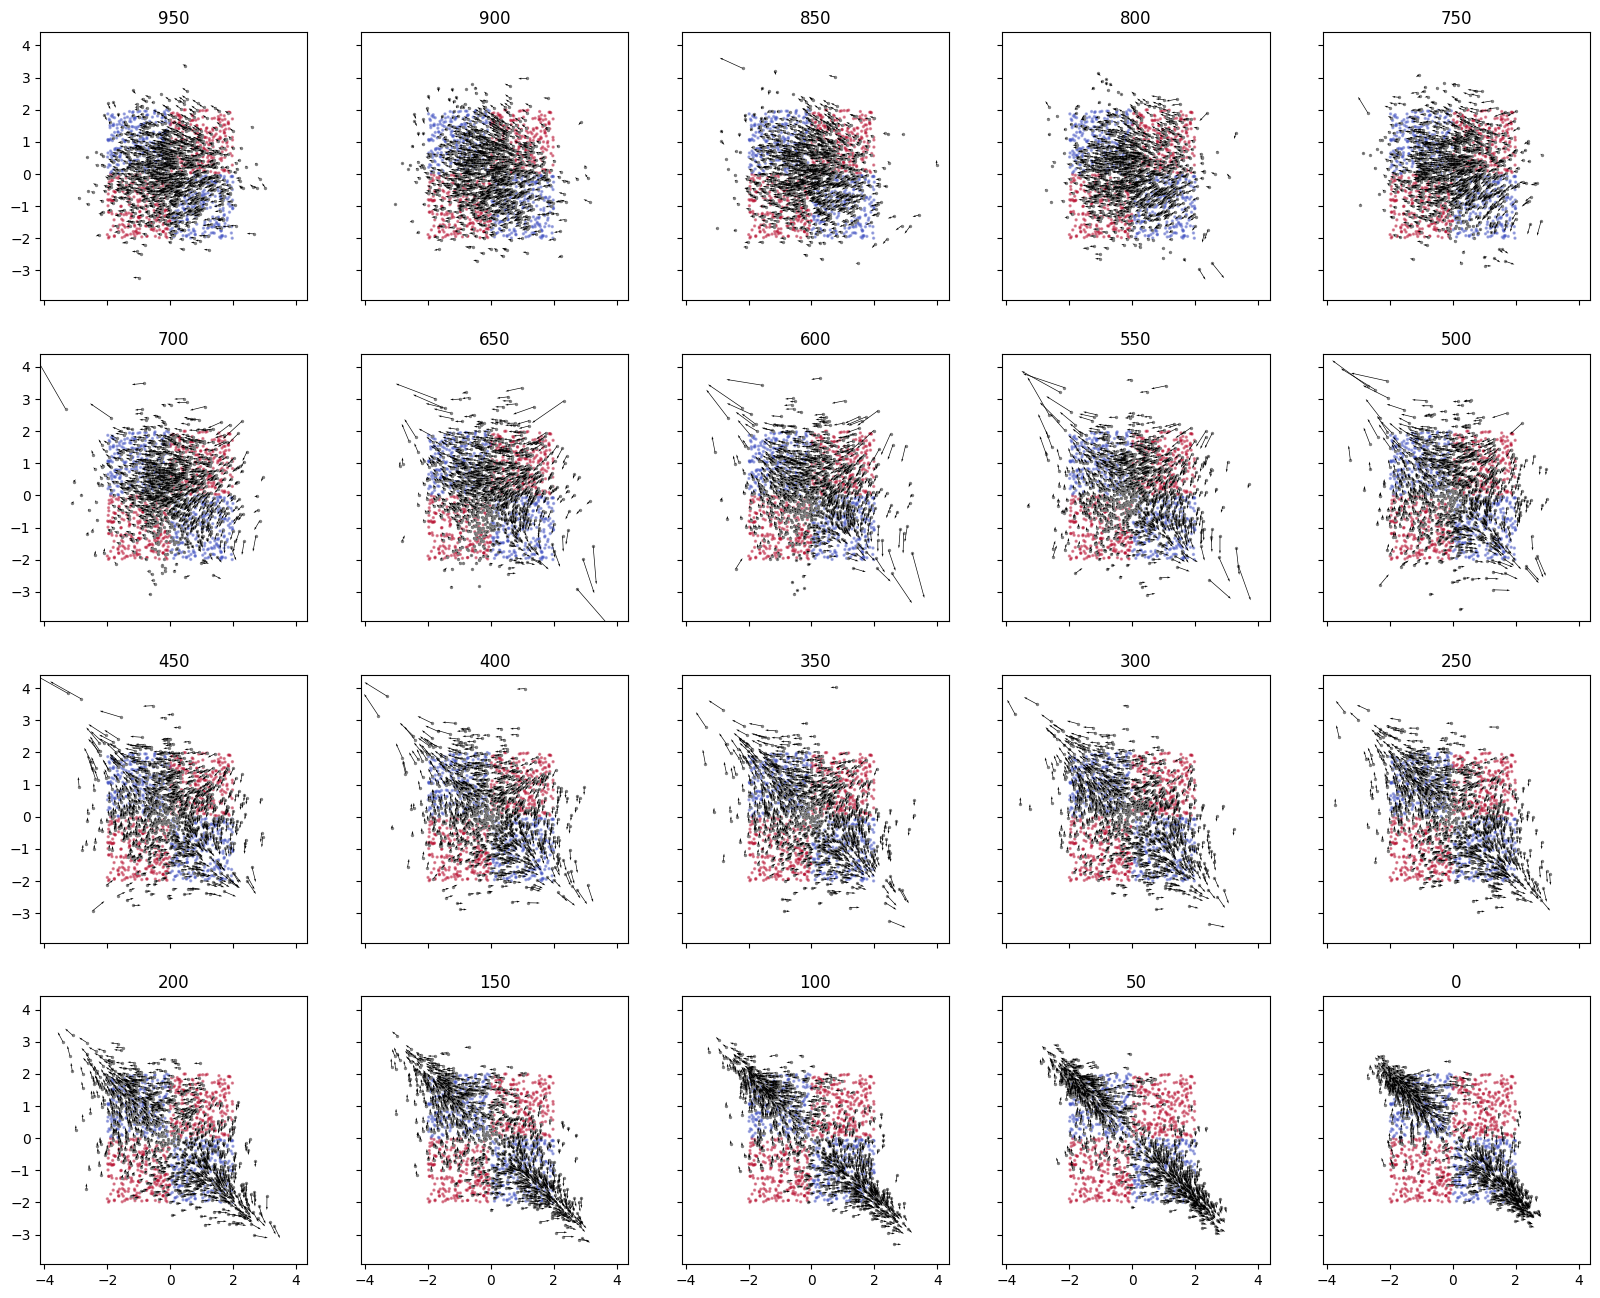

In [39]:
sample_size = 1000

x_t = torch.normal(0, 1, size=(sample_size, 2), requires_grad=True)

# TODO try different labels
# label = torch.ones((sample_size,), dtype=torch.long)
label = torch.zeros((sample_size,), dtype=torch.long)


fig, axs = plt.subplots(ncols=5,nrows=4, sharex=True, sharey=True, figsize=(20, 16))
axs = axs.flatten()
skip = T // len(axs)

for t_idx in tqdm(reversed(range(T))):
    alpha_bar = alphas_bar[t_idx]
    beta = betas[t_idx]
    alpha = alphas[t_idx]

    t = torch.tensor([t_idx]).repeat(sample_size, 1)
    inp = torch.cat([x_t.detach(), t / T], dim=1).float()
    diffusion_step = diffusion_model.forward(inp.detach())

    x_t = x_t.detach()
    classifier_grad = get_classifier_grad(classifier, inp, label)
    classifier_grad = classifier_grad[:, :2]  
    # this is a bit hacky, better with denoiser/classifier with forward(x, t) signature, and sinusoidal encoding etc.

    z = torch.normal(0, 1, size=(x_t.shape))
    added_noise = np.sqrt(beta) * z if t_idx > 0 else 0  # no noise at the end

    x_t = (1 / np.sqrt(alpha)) * (
        x_t
        - (((1 - alpha) / np.sqrt(1 - alpha_bar)) * diffusion_step)
        + beta * 1.0 *  classifier_grad      # scale of 1.0 should work
    ) + added_noise

    if t_idx % skip == 0:
        plot_idx = T // skip - 1 - t_idx // skip
        # axs[plot_idx].scatter(*x_val[y_val[:, 0] == 1].T, s=2)
        # axs[plot_idx].scatter(*x_val[y_val[:, 1] == 1].T, s=2)
        axs[plot_idx].scatter(*x_val.T, c=y_val, s=2, cmap="coolwarm", alpha=0.4)
        axs[plot_idx].scatter(
            *x_t.detach().numpy().T,
            # c=torch.softmax(class_pred, dim=1).detach().numpy()[:, 1]
            s=2,
            c="grey"
        )
        axs[plot_idx].quiver(
            *x_t.detach().numpy().T, *classifier_grad.detach().numpy().T
        )
        axs[plot_idx].set_title(t_idx)




# plt.scatter(*x_val.T, s=1)
# plt.scatter(*x_t.detach().numpy().T, s=1)
# plt.show()